In [1]:
import numpy as np
import pandas as pd
from utils import *
import warnings
# to ignore pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)
import NeuralNetwork
import matplotlib.pyplot as plt

In [2]:
col_names = ('Input1', 'Input2', 'Input3', 'Input4', 'Input5', 'Input6',
             'Input7', 'Input8', 'Input9', 'Input10', 'TARGET_x', 'TARGET_y', 'TARGET_z')
data = pd.read_csv("../ML-23-PRJ-Package/ML-CUP23-TR.csv",
                   skiprows=7, usecols=[i for i in range(1, 14)], names=col_names)

data = data.sample(frac=1)
#SPLIT 80/20 FOR TRAIN/TEST
folds = np.array_split(data, 10)
tr_data = pd.concat(folds[2:9])
test_data = pd.concat(folds[0:2])
es_data=folds[9]

In [4]:
grid={
    "eta" : [0.001],
    "mb" : [256, 512],
    "momentum" : [0.8, 0.9],
    "n_layers" : [1, 2],
    "n_neurons" : [16, 8],
    "epochs" : [100],
    "clip_value" : [None],
    "hid_act_fun" : ["relu"],
    "out_act_fun" : ["linear"],
    "cost_fun" : ["eucl"],
    "ridge_lambda": [None],
    "lasso_lambda": [None],
    "decay_max_steps": [None],
    "decay_min_value": [None],
    "es_patience": [50]
}

search_space=get_search_space(grid)
print(len(search_space))
parallel_grid_search(k = 5, data = tr_data, es_data=es_data, search_space=search_space, n_inputs=10, n_outputs=3,type="cup")

16
N_cores = 10


Training: 100%|██████████| 100/100 [00:12<00:00,  7.86epoch/s]


val_mean = 18.00912408961502


Training: 100%|██████████| 100/100 [00:12<00:00,  7.78epoch/s]


val_mean = 29.208609400280256


Training: 100%|██████████| 100/100 [00:15<00:00,  6.44epoch/s]


val_mean = 13.648486343508704


Training: 100%|██████████| 100/100 [00:15<00:00,  6.63epoch/s]


val_mean = 33.97461116614524


Training: 100%|██████████| 100/100 [00:13<00:00,  7.61epoch/s]


val_mean = 19.79184810910134


Training: 100%|██████████| 100/100 [00:14<00:00,  6.99epoch/s]


val_mean = 17.503889742323786


Training: 100%|██████████| 100/100 [00:15<00:00,  6.50epoch/s]


val_mean = 24.504456082972574


Training: 100%|██████████| 100/100 [00:16<00:00,  6.15epoch/s]


val_mean = 21.19514238835729


Training: 100%|██████████| 100/100 [00:15<00:00,  6.33epoch/s]


val_mean = 23.442614051050914


Training: 100%|██████████| 100/100 [00:15<00:00,  6.61epoch/s]


val_mean = 27.81945659680481


Training: 100%|██████████| 100/100 [00:10<00:00,  9.20epoch/s]


val_mean = 24.99664118187505


Training: 100%|██████████| 100/100 [00:09<00:00, 10.12epoch/s]


val_mean = 23.410839757516634


Training: 100%|██████████| 100/100 [00:09<00:00, 10.13epoch/s]


val_mean = 23.034924295047627


Training: 100%|██████████| 100/100 [00:11<00:00,  8.56epoch/s]


val_mean = 25.67163700716233


Training: 100%|██████████| 100/100 [00:09<00:00, 10.54epoch/s]


val_mean = 30.55747925744772


Training: 100%|██████████| 100/100 [00:09<00:00, 10.63epoch/s]


val_mean = 31.75098474510162
GRID SEARCH FINISHED
1. {'eta': 0.001, 'mb': 256, 'momentum': 0.9, 'n_layers': 1, 'n_neurons': 16, 'epochs': 100, 'clip_value': None, 'hid_act_fun': 'relu', 'out_act_fun': 'linear', 'cost_fun': 'eucl', 'ridge_lambda': None, 'lasso_lambda': None, 'decay_max_steps': None, 'decay_min_value': None, 'es_patience': 50}
Validation mean = 13.648486343508704, Variance = 3.204819669629292
Training mean (ES) = 13.479863231550775

2. {'eta': 0.001, 'mb': 256, 'momentum': 0.8, 'n_layers': 1, 'n_neurons': 16, 'epochs': 100, 'clip_value': None, 'hid_act_fun': 'relu', 'out_act_fun': 'linear', 'cost_fun': 'eucl', 'ridge_lambda': None, 'lasso_lambda': None, 'decay_max_steps': None, 'decay_min_value': None, 'es_patience': 50}
Validation mean = 17.503889742323786, Variance = 5.978259387902524
Training mean (ES) = 17.837004209557797

3. {'eta': 0.001, 'mb': 512, 'momentum': 0.9, 'n_layers': 1, 'n_neurons': 16, 'epochs': 100, 'clip_value': None, 'hid_act_fun': 'relu', 'out_act_f

Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Training: 100%|██████████| 5000/5000 [05:33<00:00, 14.98epoch/s]

TR: 1.1885496471875565


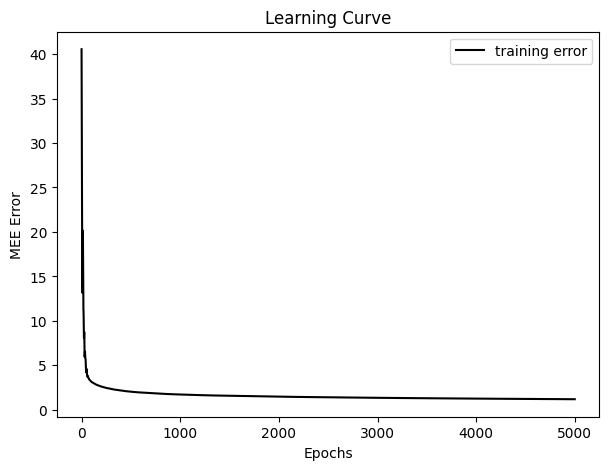

In [ ]:


params =  {'eta': 0.00001, 'mb': 64, 'momentum': 0.99, 'n_layers': 15, 'n_neurons': 500, 'epochs': 5000, 'clip_value': None, 'hid_act_fun': 'relu', 'out_act_fun': 'linear', 'cost_fun': 'eucl', 'ridge_lambda': None, 'lasso_lambda': None, 'decay_max_steps': None, 'decay_min_value': None, 'es_patience': 50}

fig,axs = plt.subplots(1,1,figsize=(7,5))

net = NeuralNetwork.NeuralNetwork(type="cup")
net.add_input_layer(10)
net.add_hidden_layer(10,params["n_neurons"])
net.add_output_layer(params["n_neurons"], 3)

tr = net.train(tr_data, params ,type="cup", es_data=es_data)
plot_loss_Cup(tr,"eucl",axs)
print(f"TR: {tr[-1]}")

